In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pandas.io.formats import style
from sklearn.model_selection import cross_val_score
from dateutil import easter as est
from datetime import datetime, timedelta

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
class integControl:
    def __init__(self, dayWeights = [1,1,1,1,1,1,1], dayErrs = [0,0,0,0,0,0,0]):
        self.dayIntegrator = dayWeights.copy();
        self.dayPrevStepErr = dayErrs.copy();
    
    def runControl(self, data:pd.DataFrame, gain=0.05):
        newPreds = [];
        for i,row in data.iterrows():
            day = int(row["DoW"])
            self.dayIntegrator[day] -= self.dayPrevStepErr[day]*gain
            newPred = self.dayIntegrator[day]*row["pred"]
            if(row["Quantity"] != 0):
                self.dayPrevStepErr[day]  = (newPred - row["Quantity"])/row["Quantity"]
            else:
                self.dayPrevStepErr[day]  = 0
            if(self.dayPrevStepErr[day]>3): self.dayPrevStepErr[day] = 0
            newPreds.append(newPred)
        return newPreds
    
    def updatePred(self, data:pd.DataFrame):
        newPreds = [];
        for i,row in data.iterrows():
            day = int(row["DoW"])
            newPreds.append(self.dayIntegrator[day]*row["pred"])
        return newPreds

In [6]:
# Restaurant raw data
rest1dat = pd.read_csv("restaurant-1-orders.csv")
rest1price = pd.read_csv("restaurant-1-products-price.csv")

rest2dat = pd.read_csv("restaurant-2-orders.csv")
rest2price = pd.read_csv("restaurant-2-products-price.csv")

# London Weather Raw Data
weatherdat = pd.read_csv("london_weather.csv")
weatherdat.columns

# UK Holidays
ukholidat = pd.read_excel("UK Holidays.xlsx")

# Indian Holidays
indholidat = pd.read_csv("indian_holidays.csv")


In [7]:
# Aggregating weather data. See: https://www.kaggle.com/code/mellisawood/weatherprediction

# Setting date formats
weatherdat = weatherdat.dropna(axis=0)
weatherdat['date'] = pd.to_datetime(weatherdat['date'], format = '%Y%m%d')

rest1dat['Order Date'] = pd.to_datetime(rest1dat['Order Date'], dayfirst = True)
rest2dat['Order Date'] = pd.to_datetime(rest2dat['Order Date'], dayfirst = True)

rest1dat.rename(columns={'Order Date':'date'}, inplace=True)
rest2dat.rename(columns={'Order Date':'date'}, inplace=True)

ukholidat['date'] = pd.to_datetime(ukholidat['date'], dayfirst = True).dt.date
indholidat['offdate'] = pd.to_datetime(indholidat['offdate'], dayfirst = True).dt.date

# Creating data sets for quantity analysis See: https://www.kaggle.com/code/malhardata/sales-forecasting-model

rest1grouped = rest1dat[['date', 'Quantity']].resample('D', on='date').sum().reset_index()
rest2grouped = rest2dat[['date', 'Quantity']].resample('D', on='date').sum().reset_index()

In [8]:
# construct indian holidays dataframe
Ihol2019 = indholidat.copy()
for rIndex, row in Ihol2019.iterrows():
    if row["offdate"].year!=2019:
        Ihol2019.drop(rIndex, inplace=True)
Ihol2019.rename(columns = {'offdate':'date', 'event':'holiday'}, inplace = True)

# construct uk holidays dataframe
Uhol2019 = ukholidat.copy()
Uhol2019.drop(['countryOrRegion','holidayName','isPaidTimeOff','countryRegionCode'], inplace=True, axis=1)
for rIndex, row in Uhol2019.iterrows():
    if row["date"].year!=2019:
        Uhol2019.drop(rIndex, inplace=True)
Uhol2019.rename(columns = {'normalizeHolidayName':'holiday'}, inplace = True)
columns_titles = ['date','holiday']
Uhol2019=Uhol2019.reindex(columns=columns_titles)

hol2019=pd.concat([Ihol2019,Uhol2019])
hol2019['MoY'] = [x.month for x in hol2019.date]
hol2019['DoM'] = [x.day for x in hol2019.date]
hol2019['DoW'] = [x.weekday() for x in hol2019.date]
hol2019.sort_values(['MoY', 'DoM'], ascending = [True, True],inplace=True)
hol2019.drop([33,50,164,165], inplace=True) #remove duplicates and easter
hol2019.reset_index(drop=True, inplace=True)
hol2019.drop([0], inplace=True) #removes new years duplicate
# print(hol2019)
hol2019.reset_index(inplace=True)
hol2019.rename(columns = {'index':'hId'}, inplace = True)
hol2019.drop(["date", "holiday"], inplace=True, axis=1)

In [9]:
# function to construct dataframe for all days in a given range
def create_date_table(start='2000-01-01', end='2050-12-31'):
    start_ts = pd.to_datetime(start).date()
    end_ts = pd.to_datetime(end).date()
    dates = pd.date_range(start_ts, end_ts)
    df =  pd.DataFrame(index=range(dates.size))
    hIDarr = []
    for date in dates:
        hIDarr.append(ret_hID(date.year,date.month,date.day,date.dayofweek))
    
    df['DoM'] = dates.day
    df['MoY'] = dates.month
    df['DoW'] = dates.dayofweek
    df["hID"] = hIDarr
    
    return df

def ret_hID(year, month, monthDay, weekDay):
    day = 0
    for index, row in hol2019.iterrows():
        if(row["MoY"]==month and row["DoM"]==monthDay):
            day = row["hId"]
    estrWknd = [est.easter(year) - timedelta(days=2),est.easter(year) - timedelta(days=1),est.easter(year),est.easter(year) + timedelta(days=1)]
    for i, estr in enumerate(estrWknd):
        if(estr.month==month and estr.day==monthDay):
            day = len(hol2019.index)+1+i
    return day

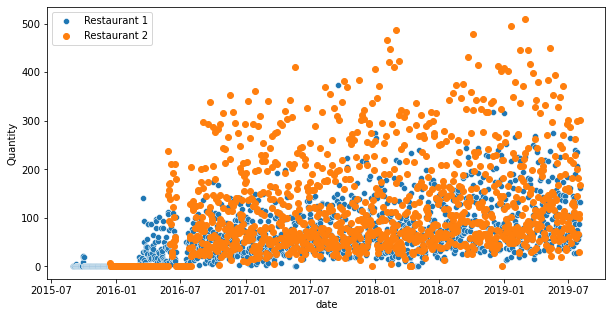

In [10]:
# Visualise the quantity size data as a function of time to select best data set 

plt.figure(figsize = (10,5))
sns.scatterplot(x = rest1grouped['date'], y = rest1grouped['Quantity'], label = 'Restaurant 1')
plt.scatter(x = rest2grouped['date'], y = rest2grouped['Quantity'],label='Restaurant 2')
plt.legend()
plt.show()


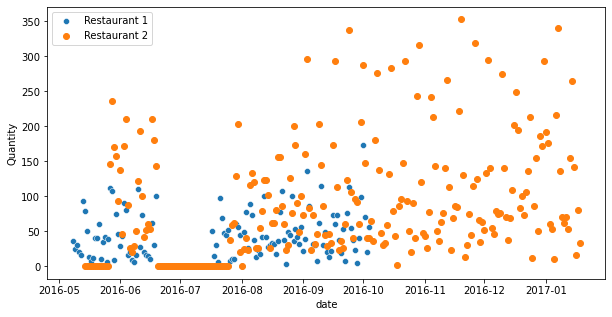

In [11]:
# Zooming in to see the precise data time to select the best quality data.
plt.figure(figsize = (10,5))
sns.scatterplot(x = rest1grouped['date'].iloc[250:400], y = rest1grouped['Quantity'].iloc[250:400], label = 'Restaurant 1')
plt.scatter(x = rest2grouped['date'].iloc[150:400], y = rest2grouped['Quantity'].iloc[150:400],label='Restaurant 2')
plt.legend()
plt.show()

In [12]:
# Conclusion is data with best quality is above 2016-08-01

rest1dat = rest1dat.loc[rest1dat['date'] >='2016-08-01' ].sort_values(by = 'date',ascending= True)
rest2dat = rest2dat.loc[rest2dat['date'] >='2016-08-01' ].sort_values(by = 'date',ascending= True)

weatherdat = weatherdat.loc[weatherdat['date'] >='2016-08-01']
weatherdat = weatherdat.loc[weatherdat['date'] <= '2019-08-03']

In [13]:
rest1dat

,Order Number,date,Item Name,Quantity,Product Price,Total products
72423,2818,2016-08-02 02:03:00,Prawn Balti,1,10.95,7
38653,2818,2016-08-02 02:03:00,Bengal Salad,1,3.95,7
38652,2818,2016-08-02 02:03:00,French Fries,1,3.95,7
70941,2818,2016-08-02 02:03:00,Lamb Balti,1,9.95,7
72424,2818,2016-08-02 02:03:00,Chicken Tikka Biryani,1,10.95,7
...,...,...,...,...,...,...
4,16118,2019-08-03 20:25:00,Paneer Tikka Masala,1,8.95,6
3,16118,2019-08-03 20:25:00,Mushroom Rice,1,3.95,6
2,16118,2019-08-03 20:25:00,Garlic Naan,1,2.95,6
1,16118,2019-08-03 20:25:00,King Prawn Balti,1,12.95,6


In [14]:
poprest1 = rest1dat.groupby('Item Name').sum().sort_values(by = 'Product Price', ascending = 0)
poprest1.head(5)

,Order Number,Quantity,Product Price,Total products
Item Name,,,,
Chicken Tikka Masala,19081081,2367,18275.90,13786
Pilau Rice,42968191,6113,13351.70,29924
Bombay Aloo,15902218,1754,9984.10,11812
Korma,6603439,1256,9903.25,7098
Plain Naan,33553574,4751,9310.60,23118


In [15]:
poprest2 = rest2dat.groupby('Item Name').sum().sort_values(by = 'Product Price', ascending = 0)
poprest2.head(5)

,Order ID,Quantity,Product Price,Total products
Item Name,,,,
Chicken Tikka Masala,52076304,3860,30421.05,24224
Pilau Rice,126067679,11481,24145.75,56410
Bombay Aloo,62451519,4243,24038.00,27812
Naan,99035356,8544,16330.00,43966
Korma,17311044,1968,15046.35,12172


In [51]:
# Pick top 2 items from each restaurant in product price (heuristic: intersection with non-condiment volume, highest possible gains).
# Check: Confusion matrix

dfr1 = rest1dat[['date','Quantity']]
dfr1tkm = rest1dat[rest1dat['Item Name'] == 'Chicken Tikka Masala']
dfr1pr =rest1dat[rest1dat['Item Name'] == 'Pilau Rice']


# Order by Date and quantity

dfr1 = dfr1.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')
dfr1tkm = dfr1tkm.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')
dfr1pr = dfr1pr.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')


# Date - Month - Year
dfr1['DoW'] = dfr1['date'].dt.dayofweek
dfr1['DoM'] = dfr1['date'].dt.day
dfr1['MoY'] = dfr1['date'].dt.month

dfr1tkm['DoW'] = dfr1tkm['date'].dt.dayofweek
dfr1tkm['DoM'] = dfr1tkm['date'].dt.day
dfr1tkm['MoY'] = dfr1tkm['date'].dt.month

dfr1pr['DoW'] = dfr1pr['date'].dt.dayofweek
dfr1pr['DoM'] = dfr1pr['date'].dt.day
dfr1pr['MoY'] = dfr1pr['date'].dt.month


# Feature engineering based on on std metric of Chicken Tikka Masala - https://www.kaggle.com/code/malhardata/sales-forecasting-model
# Up to 3 standard deviations ahead in the future prediciton.

for i in range (1,6):
    label = "Quantity_" + str(i)
    dfr1[label] = dfr1['Quantity'].shift(i)
    dfr1tkm[label] = dfr1tkm['Quantity'].shift(i)
    dfr1pr[label] = dfr1pr['Quantity'].shift(i)
    label = "Average_" + str(i)
    dfr1[label] = dfr1['Quantity'].rolling(i).mean().shift(1)
    dfr1tkm[label] = dfr1tkm['Quantity'].rolling(i).mean().shift(1)
    dfr1pr[label] = dfr1pr['Quantity'].rolling(i).mean().shift(1)

dfr1 = dfr1.dropna()
dfr1tkm = dfr1tkm.dropna()
dfr1pr = dfr1pr.dropna()


In [52]:
# Pick top 2 items from each restaurant in product price (heuristic: intersection with non-condiment volume, highest possible gains).
# Check: Confusion matrix

dfr2 = rest2dat[['date','Quantity']]
dfr2tkm = rest2dat[rest2dat['Item Name'] == 'Chicken Tikka Masala']
dfr2pr =rest2dat[rest2dat['Item Name'] == 'Pilau Rice']


# Order by Date and quantity

dfr2 = dfr2.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')
dfr2tkm = dfr2tkm.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')
dfr2pr = dfr2pr.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')


# Date - Month - Year
dfr2['DoW'] = dfr2['date'].dt.dayofweek
dfr2['DoM'] = dfr2['date'].dt.day
dfr2['MoY'] = dfr2['date'].dt.month

dfr2tkm['DoW'] = dfr2tkm['date'].dt.dayofweek
dfr2tkm['DoM'] = dfr2tkm['date'].dt.day
dfr2tkm['MoY'] = dfr2tkm['date'].dt.month

dfr2pr['DoW'] = dfr2pr['date'].dt.dayofweek
dfr2pr['DoM'] = dfr2pr['date'].dt.day
dfr2pr['MoY'] = dfr2pr['date'].dt.month


# Feature engineering based on on std metric of Chicken Tikka Masala - https://www.kaggle.com/code/malhardata/sales-forecasting-model
# Up to 3 standard deviations ahead in the future prediciton.

for i in range (1,6):
    label = "Quantity_" + str(i)
    dfr2[label] = dfr2['Quantity'].shift(i)
    dfr2tkm[label] = dfr2tkm['Quantity'].shift(i)
    dfr2pr[label] = dfr2pr['Quantity'].shift(i)
    label = "Average_" + str(i)
    dfr2[label] = dfr2['Quantity'].rolling(i).mean().shift(1)
    dfr2tkm[label] = dfr2tkm['Quantity'].rolling(i).mean().shift(1)
    dfr2pr[label] = dfr2pr['Quantity'].rolling(i).mean().shift(1)

dfr2 = dfr2.dropna()
dfr2tkm = dfr2tkm.dropna()
dfr2pr = dfr2pr.dropna()

In [53]:
# Now we concatenate the data set to weather data 

dfr1 = pd.merge(dfr1,weatherdat,on='date',how='outer').dropna()
dfr1tkm = pd.merge(dfr1tkm,weatherdat,on='date',how='outer').dropna()
dfr1pr = pd.merge(dfr1pr,weatherdat,on='date',how='outer').dropna()

dfr2 = pd.merge(dfr2,weatherdat,on='date',how='outer').dropna()
dfr2tkm = pd.merge(dfr2tkm,weatherdat,on='date',how='outer').dropna()
dfr2pr = pd.merge(dfr2pr,weatherdat,on='date',how='outer').dropna()

In [54]:
# Concatenate data+weather to holidays :)

dfr1 = pd.merge(dfr1,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()
dfr1tkm = pd.merge(dfr1tkm,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()
dfr1pr = pd.merge(dfr1pr,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()

dfr2 = pd.merge(dfr2,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()
dfr2tkm = pd.merge(dfr2tkm,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()
dfr2pr = pd.merge(dfr2pr,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()

In [55]:
# Convert Dates to Int for train_test_split
dfr1['date'] = pd.to_datetime(dfr1['date']).dt.strftime("%Y%m%d").astype(int)
dfr1tkm['date'] = pd.to_datetime(dfr1tkm['date']).dt.strftime("%Y%m%d").astype(int)
dfr1pr['date'] = pd.to_datetime(dfr1pr['date']).dt.strftime("%Y%m%d").astype(int)

dfr2['date'] = pd.to_datetime(dfr2['date']).dt.strftime("%Y%m%d").astype(int)
dfr2tkm['date'] = pd.to_datetime(dfr2tkm['date']).dt.strftime("%Y%m%d").astype(int)
dfr2tkm['date'] = pd.to_datetime(dfr2tkm['date']).dt.strftime("%Y%m%d").astype(int)

In [56]:
# Use correlation matrix to investigate elements

def Correlation_Matrix(X,Y):
    
    corrS = X.corr()
    corrB = Y.corr()
    cmap = cmap =sns.diverging_palette(5, 250, as_cmap=True)
    def magnify():
        return [dict(selector="th",
                     props=[("font-size", "7pt")]),
                dict(selector="td",
                     props=[('padding', "0em 0em")]),
                dict(selector="th:hover",
                     props=[("font-size", "12pt")]),
                dict(selector="tr:hover td:hover",
                     props=[('max-width', '200px'),
                            ('font-size', '12pt')])
    ]

    S_corrmatrix = corrS.style.background_gradient(cmap, axis=0)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Hover to magify")\
        .set_precision(2)\
        .set_table_styles(magnify())
    B_corrmatrix = corrB.style.background_gradient(cmap, axis=0)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Hover to magify")\
        .set_precision(2)\
        .set_table_styles(magnify())
    return S_corrmatrix, B_corrmatrix

matrixS, matrixB = Correlation_Matrix(dfr1,dfr1)

C:\Users\Jeroen\AppData\Local\Temp/ipykernel_6708/1133580162.py:20: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  S_corrmatrix = corrS.style.background_gradient(cmap, axis=0)\
C:\Users\Jeroen\AppData\Local\Temp/ipykernel_6708/1133580162.py:25: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  B_corrmatrix = corrB.style.background_gradient(cmap, axis=0)\


In [57]:
matrixS

,date,Quantity,DoW,DoM,MoY,Quantity_1,Average_1,Quantity_2,Average_2,Quantity_3,Average_3,Quantity_4,Average_4,Quantity_5,Average_5,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,hID
date,1.00,0.26,-0.00,-0.02,-0.41,0.26,0.26,0.26,0.32,0.27,0.38,0.27,0.46,0.27,0.54,-0.03,0.11,0.15,0.04,-0.00,-0.04,0.01,-0.09,0.03,-0.05
Quantity,0.26,1.00,0.49,0.02,0.04,0.36,0.36,-0.08,0.17,-0.24,0.02,-0.25,-0.09,-0.06,-0.11,0.04,-0.05,-0.04,-0.02,-0.03,-0.03,0.04,-0.03,0.03,0.02
DoW,-0.00,0.49,1.00,-0.01,0.01,0.46,0.46,-0.14,0.19,-0.57,-0.12,-0.35,-0.26,-0.09,-0.29,0.01,-0.01,-0.02,-0.01,-0.00,0.00,0.03,-0.04,0.05,0.04
DoM,-0.02,0.02,-0.01,1.00,0.01,-0.02,-0.02,-0.01,-0.01,0.01,-0.01,0.01,-0.00,-0.01,-0.01,-0.02,-0.01,-0.03,0.03,0.03,0.03,-0.01,0.09,-0.02,-0.01
MoY,-0.41,0.04,0.01,0.01,1.00,0.01,0.01,0.00,0.01,0.00,0.01,-0.00,0.01,-0.00,0.00,-0.03,-0.03,-0.09,0.16,0.21,0.24,0.02,0.08,-0.04,0.09
Quantity_1,0.26,0.36,0.46,-0.02,0.01,1.00,1.00,0.36,0.82,-0.08,0.62,-0.25,0.45,-0.25,0.32,-0.01,-0.01,-0.02,-0.01,-0.02,-0.03,0.01,-0.01,0.06,0.03
Average_1,0.26,0.36,0.46,-0.02,0.01,1.00,1.00,0.36,0.82,-0.08,0.62,-0.25,0.45,-0.25,0.32,-0.01,-0.01,-0.02,-0.01,-0.02,-0.03,0.01,-0.01,0.06,0.03
Quantity_2,0.26,-0.08,-0.14,-0.01,0.00,0.36,0.36,1.00,0.82,0.36,0.83,-0.08,0.71,-0.25,0.57,-0.02,0.00,-0.01,-0.01,-0.02,-0.03,0.00,0.04,0.02,0.04
Average_2,0.32,0.17,0.19,-0.01,0.01,0.82,0.82,0.82,1.00,0.17,0.88,-0.20,0.70,-0.30,0.54,-0.02,-0.01,-0.02,-0.02,-0.03,-0.03,0.01,0.02,0.04,0.04
Quantity_3,0.27,-0.24,-0.57,0.01,0.00,-0.08,-0.08,0.36,0.17,1.00,0.62,0.36,0.71,-0.08,0.64,0.01,-0.02,0.00,-0.01,-0.02,-0.02,0.04,0.03,-0.03,-0.02


In [58]:
# Cross-validation before setting model parameters based on MAE.

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', XGBRegressor(n_estimators=500,random_state=0,learning_rate=0.01))
                             ])

In [59]:
# # Multiply by -1 since sklearn calculates *negative* MAE
# scores = -1 * cross_val_score(my_pipeline, dfr1x, dfr1y,
#                               cv=50,
#                               scoring='neg_mean_absolute_error')

# print("MAE scores:\n", scores)

In [60]:
# sns.scatterplot(x=np.arange(0,1,0.02),y=scores)
# plt.xlabel('Split size')
# plt.ylabel('MAE Score')
# plt.show()

In [61]:
# Defining output vectors
dfr1y = dfr1['Quantity']
dfr1tkmy = dfr1tkm['Quantity']
dfr1pry = dfr1pr['Quantity']

dfr2y = dfr2['Quantity']
dfr2tkmy = dfr2tkm['Quantity']
dfr2pry = dfr2pr['Quantity']

In [62]:
dfr1[800:]

,date,Quantity,DoW,DoM,MoY,Quantity_1,Average_1,Quantity_2,Average_2,Quantity_3,...,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,hID
800,20181021,57.0,6.0,21.0,10.0,193.0,193.0,245.0,219.0,87.0,...,2.0,8.7,111.0,13.7,13.7,8.2,0.0,102830.0,0.0,0
801,20181022,37.0,0.0,22.0,10.0,57.0,57.0,193.0,125.0,245.0,...,1.0,9.1,112.0,16.0,10.2,6.8,0.0,103630.0,0.0,0
802,20181023,37.0,1.0,23.0,10.0,37.0,37.0,57.0,47.0,193.0,...,2.0,3.3,68.0,17.9,10.9,5.8,0.0,103120.0,0.0,0
803,20181024,51.0,2.0,24.0,10.0,37.0,37.0,37.0,37.0,57.0,...,2.0,5.2,82.0,15.0,13.7,9.5,0.0,102840.0,0.0,0
804,20181025,30.0,3.0,25.0,10.0,51.0,51.0,37.0,44.0,37.0,...,5.0,5.9,86.0,11.4,10.2,5.3,1.0,102190.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,20190730,100.0,1.0,30.0,7.0,57.0,57.0,133.0,95.0,235.0,...,6.0,1.5,124.0,24.9,18.4,17.0,3.8,100510.0,0.0,0
1083,20190731,87.0,2.0,31.0,7.0,100.0,100.0,57.0,78.5,133.0,...,7.0,4.2,176.0,26.0,20.6,16.3,0.0,101230.0,0.0,0
1084,20190801,65.0,3.0,1.0,8.0,87.0,87.0,100.0,93.5,57.0,...,6.0,5.7,199.0,25.8,20.3,14.6,0.0,101710.0,0.0,0
1085,20190802,132.0,4.0,2.0,8.0,65.0,65.0,87.0,76.0,100.0,...,4.0,6.6,212.0,24.7,20.6,15.5,0.0,101910.0,0.0,0


In [63]:
# X_traindate, X_testdate, y_train, y_test = train_test_split(dfr1,dfr1y, test_size=0.18, random_state=11)
# X_train = X_traindate.drop(['date'],axis=1).drop(['Quantity'],axis=1)
# X_test = X_testdate.drop(['date'],axis=1).drop(['Quantity'],axis=1)

X_traindate = dfr1[:800]
X_train = X_traindate.drop(['date'],axis=1).drop(['Quantity'],axis=1)

X_testdate = dfr1[800:]
X_test = X_testdate.drop(['date'],axis=1).drop(['Quantity'],axis=1)

y_train = dfr1y[:800]
y_test = dfr1y[800:]


# Predict daily demand and then week demand, weather information and holidays (seasons)
# Defining features and outputs
# Features: {Date, Cloud Cover, Sunshine, Mean Temp, Precipitation} and Ouput: Quantity

# dfr1x = dfr1
# dfr1tkmx = dfr1tkm.drop(['Quantity'],axis=1)
# dfr1prx = dfr1pr.drop(['Quantity'],axis=1)



# dfr2x = dfr2.drop(['Quantity'],axis=1)
# dfr2tkmx = dfr2tkm.drop(['Quantity'],axis=1)
# dfr2prx = dfr2pr.drop(['Quantity'],axis=1)


In [64]:
# train and predict for restaurant 1
quant_model = XGBRegressor(n_estimators=500,learning_rate=0.11)
val_set = [(X_train,y_train)]
quant_model.fit(X_train, y_train,eval_set=val_set,verbose=False)

pred = quant_model.predict(X_test)
score = quant_model.score(X_train,y_train)
score

0.9999989054082385

In [65]:
# format data into single DataFrame
pred = pd.Series(pred)
pred_set = X_testdate.reset_index(drop=True)
pred_set['pred'] = pred
pred_set['date'] = pd.to_datetime(pred_set['date'].astype(str), format="%Y%m%d")

error: 34.1204266365036%


Text(0, 0.5, 'error(%)')

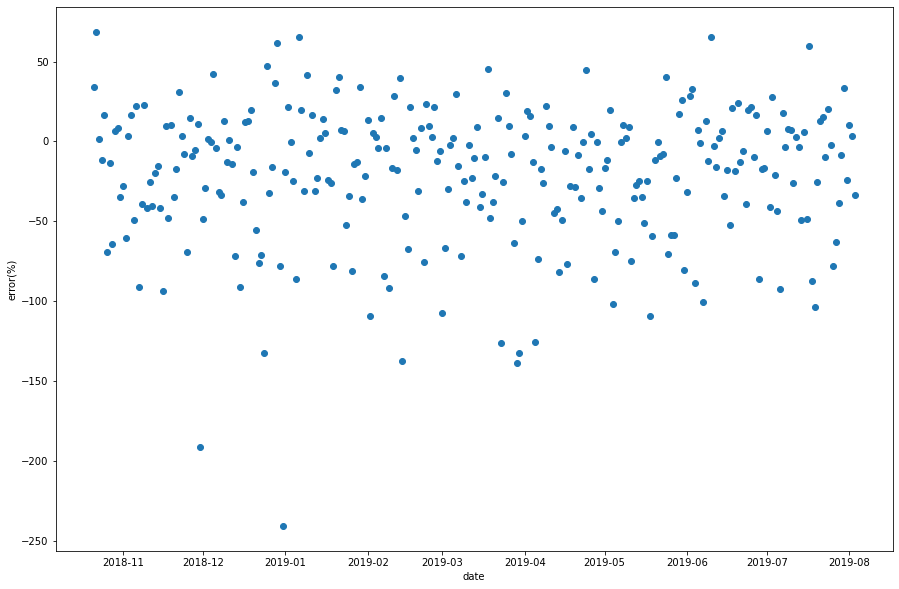

In [66]:
# calculate the prediction errors
dayPrevStepErr = (pred_set.pred - pred_set.Quantity)/(pred_set.Quantity.mean())*100
dayPrevStepErr[dayPrevStepErr > 1e308] = 0
print("error: " + str(np.average(np.absolute(dayPrevStepErr))) + "%")

# plot error
plt.figure(figsize=(15,10))
plt.scatter(pred_set["date"], dayPrevStepErr)
plt.xlabel("date")
plt.ylabel("error(%)")
# plt.title("Prediction error when using only weather, date and holiday data")
# plt.savefig("uninformedPrediction.jpg", dpi=300)


In [67]:
# identify the outliers outside of a certain range
outliers = [x for i,x in enumerate(dayPrevStepErr) if (np.abs(x)>250)]
outlierIndex = [i for i,x in enumerate(dayPrevStepErr) if (np.abs(x)>250)]
OutlierDF = pred_set.loc[outlierIndex]
OutlierDF["error"] = outliers
OutlierDF

,date,Quantity,DoW,DoM,MoY,Quantity_1,Average_1,Quantity_2,Average_2,Quantity_3,...,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,hID,pred,error


Base error: 34.1204266365036%
Cs error: 32.43687067705386%


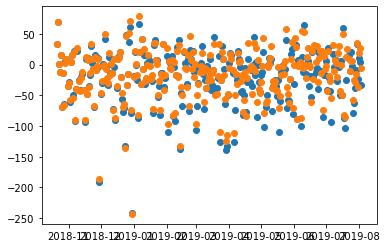

In [68]:
# Perform Integral Control on first restaurant data
R1BIC = integControl()
updatedPred = R1BIC.runControl(pred_set)
# updatedPred = R1BIC.runControl(pred_set)

dayUpdatedStepErr = (updatedPred - pred_set.Quantity)/(pred_set.Quantity.mean())*100
dayUpdatedStepErr[dayUpdatedStepErr > 1e308] = 0

print("Base error: " + str(np.average(np.absolute(dayPrevStepErr))) + "%")
print("Cs error: " + str(np.average(np.absolute(dayUpdatedStepErr))) + "%")

plt.scatter(pred_set["date"], dayPrevStepErr)
plt.scatter(pred_set["date"], dayUpdatedStepErr)

error: 38.73505144197162%


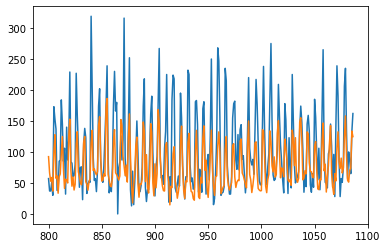

In [69]:
# Perform extrapolative predictions
daysToPred = 290;
startIndex = 800;
preData = dfr1[startIndex-6:startIndex].Quantity.copy()
extrapData = dfr1[startIndex:startIndex+daysToPred].copy()
for rIndex,row in extrapData.iterrows():
    for i in range (1,6):
        label = "Quantity_" + str(i)
        extrapData.at[rIndex,label] = preData[rIndex-i]
        label = "Average_" + str(i)
        extrapData.at[rIndex,label] = preData.rolling(i).mean()[rIndex-1]
    prediction = quant_model.predict(extrapData.loc[rIndex].to_frame().T.drop(['date'],axis=1).drop(['Quantity'],axis=1))
    preData = preData.append(pd.Series(prediction, index=[rIndex]))

df = pd.concat([preData.copy(), dfr1[startIndex:startIndex+daysToPred].Quantity.copy()], axis=1)
df = df.set_axis(['pred', 'quant'], axis='columns')
df = df.dropna()
predError = (df["pred"]-df["quant"])/df["quant"]*100
df["error"] = predError
predError[predError > 1e308] = 0

print("error: " + str(np.average(np.absolute(predError))) + "%")
plt.plot(df.quant)
plt.plot(df.pred)

Base error: 38.73505144197162%
Cs error: 36.89378312717807%


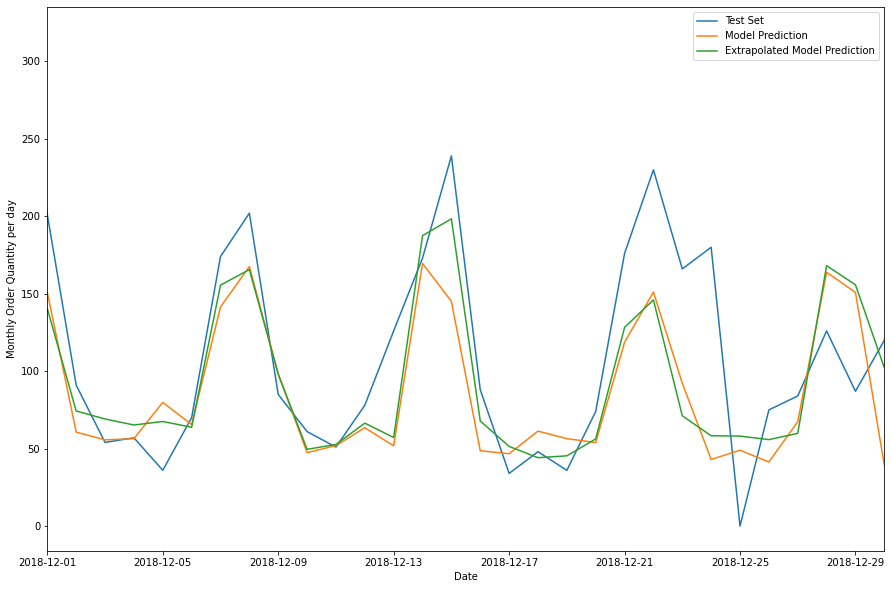

In [70]:
# perform integral control on extrapolated data of restaurant 1
extrap_pred_set = dfr1[startIndex:startIndex+daysToPred].copy()
extrap_pred_set["pred"] = preData.copy()
extrap_pred_set = extrap_pred_set.dropna()
extrap_pred_set['date'] = pd.to_datetime(extrap_pred_set['date'].astype(str), format="%Y%m%d")

R1EIC = integControl()
updatedPred = R1EIC.runControl(extrap_pred_set)

extrapPredErr = (updatedPred - extrap_pred_set.Quantity)/extrap_pred_set.Quantity*100
extrapPredErr[extrapPredErr > 1e308] = 0

print("Base error: " + str(np.average(np.absolute(predError))) + "%")
print("Cs error: " + str(np.average(np.absolute(extrapPredErr))) + "%")

plt.figure(figsize=(15,10))

plt.plot(extrap_pred_set["date"], extrap_pred_set.Quantity, label = "Test Set")
plt.plot(pred_set["date"], pred_set["pred"], label = "Model Prediction")
plt.plot(extrap_pred_set["date"], updatedPred, label = "Extrapolated Model Prediction")
plt.xlim(pd.Timestamp('2018-12-01'), pd.Timestamp('2018-12-30'))
plt.legend()
plt.xlabel('Date')
plt.ylabel('Monthly Order Quantity per day')
plt.savefig("extrapPred.jpg", dpi=300, bbox_inches = "tight")

In [71]:
# predict restaurant 2 quantities based on restaurant 1 model
rest2AllTest = dfr2.drop(['date'],axis=1).drop(['Quantity'],axis=1)
rest2AllPred = quant_model.predict(rest2AllTest)

# format data into single DataFrame
rest2PredSet = dfr2.reset_index(drop=True)
rest2PredSet['pred'] = rest2AllPred
rest2PredSet['date'] = pd.to_datetime(rest2PredSet['date'].astype(str), format="%Y%m%d")

rest2 Base error: 46.81403302525902%


Text(0, 0.5, 'error(%)')

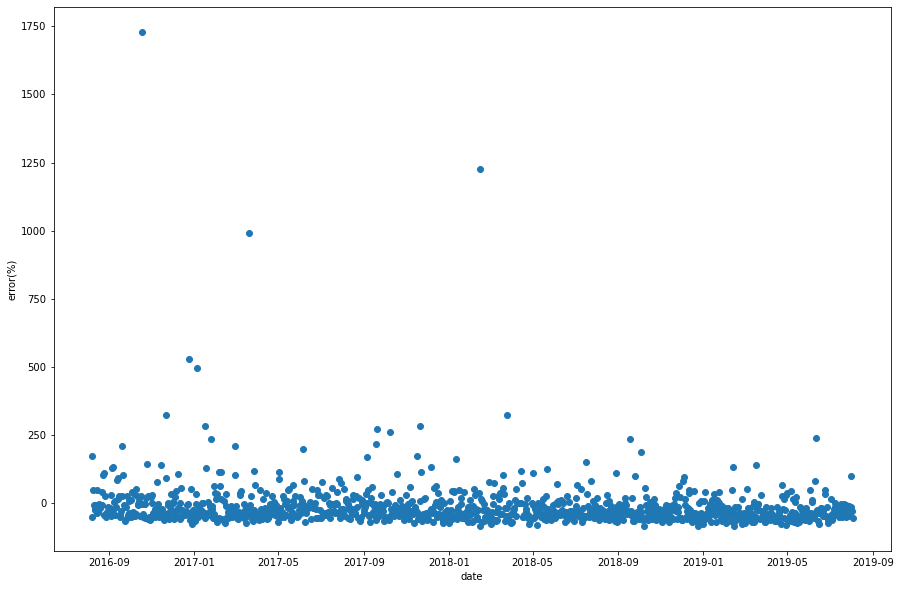

In [72]:
# calculate the prediction errors
rest2BasePredErr = (rest2PredSet.pred - rest2PredSet.Quantity)/rest2PredSet.Quantity*100
rest2BasePredErr[rest2BasePredErr > 1e308] = 0
print("rest2 Base error: " + str(np.average(np.absolute(rest2BasePredErr))) + "%")

# plot error
plt.figure(figsize=(15,10))
plt.scatter(rest2PredSet["date"], rest2BasePredErr)
plt.xlabel("date")
plt.ylabel("error(%)")

rest2 Base weekly error: 42.64347198237828%


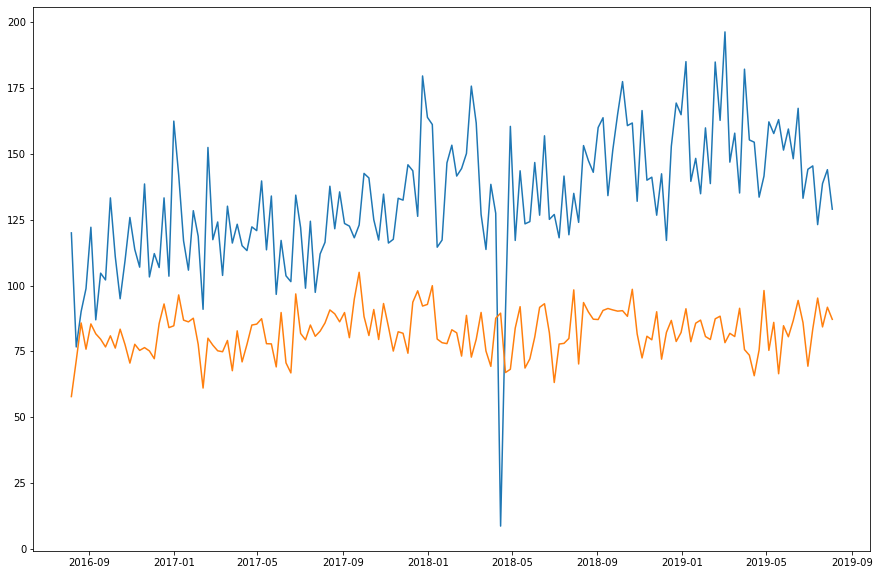

In [73]:
# weekly aggregation of data
rest2WeeklyAggregate = rest2PredSet.groupby([pd.Grouper(key='date', freq='W')])[['Quantity','pred']].mean().reset_index().sort_values('date')

# weekly aggregation error
rest2WeeklyErr = (rest2WeeklyAggregate.pred - rest2WeeklyAggregate.Quantity)/rest2WeeklyAggregate.Quantity*100
rest2WeeklyErr[rest2WeeklyErr > 1e308] = 0
print("rest2 Base weekly error: " + str(np.average(np.absolute(rest2WeeklyErr))) + "%")

plt.figure(figsize=(15,10))
plt.plot(rest2WeeklyAggregate["date"], rest2WeeklyAggregate["Quantity"])
plt.plot(rest2WeeklyAggregate["date"], rest2WeeklyAggregate["pred"])

rest2 Weekly cs error: 22.8437754127144%


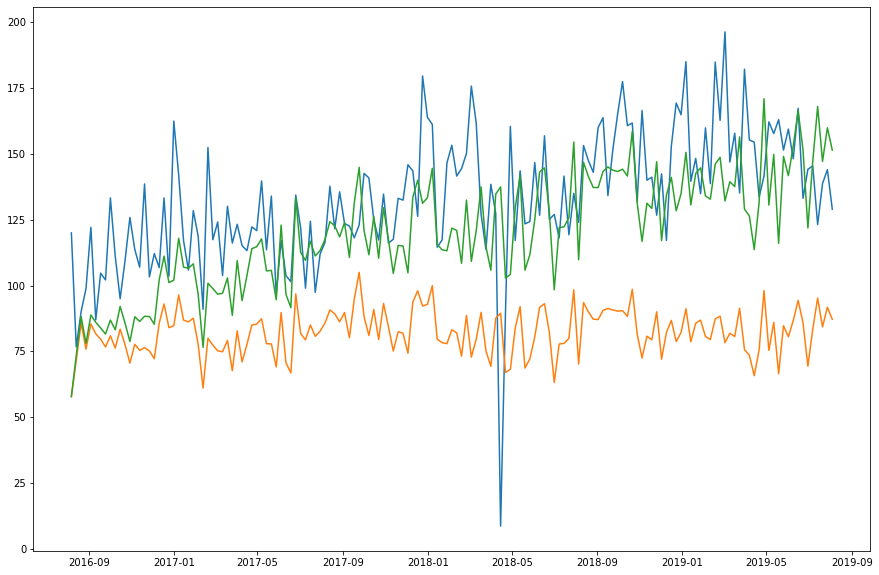

In [74]:
# Construct integration controller for weekly data
dayIntegrator = 1;
newPreds = [];
dayPrevStepErr = 0;
for i,row in rest2WeeklyAggregate.iterrows():
    dayIntegrator -= dayPrevStepErr*0.05
    newPred = dayIntegrator*row["pred"]
    if(row["Quantity"] != 0): dayPrevStepErr = (newPred - row["Quantity"])/row["Quantity"]
    else: dayPrevStepErr = 0
    if(dayPrevStepErr>3): dayPrevStepErr = 0
    newPreds.append(newPred)

# weekly cs error calculation
rest2WeeklyCSErr = (newPreds - rest2WeeklyAggregate.Quantity)/rest2WeeklyAggregate.Quantity*100
rest2WeeklyCSErr[rest2WeeklyCSErr > 1e308] = 0
print("rest2 Weekly cs error: " + str(np.average(np.absolute(rest2WeeklyCSErr))) + "%")
    
plt.figure(figsize=(15,10))
plt.plot(rest2WeeklyAggregate["date"], rest2WeeklyAggregate["Quantity"])
plt.plot(rest2WeeklyAggregate["date"], rest2WeeklyAggregate["pred"])
plt.plot(rest2WeeklyAggregate["date"], newPreds)



rest2 Base error: 46.81403302525902%
rest2 Cs error: 40.26256466349412%
error improvement: 13.994667706219602%


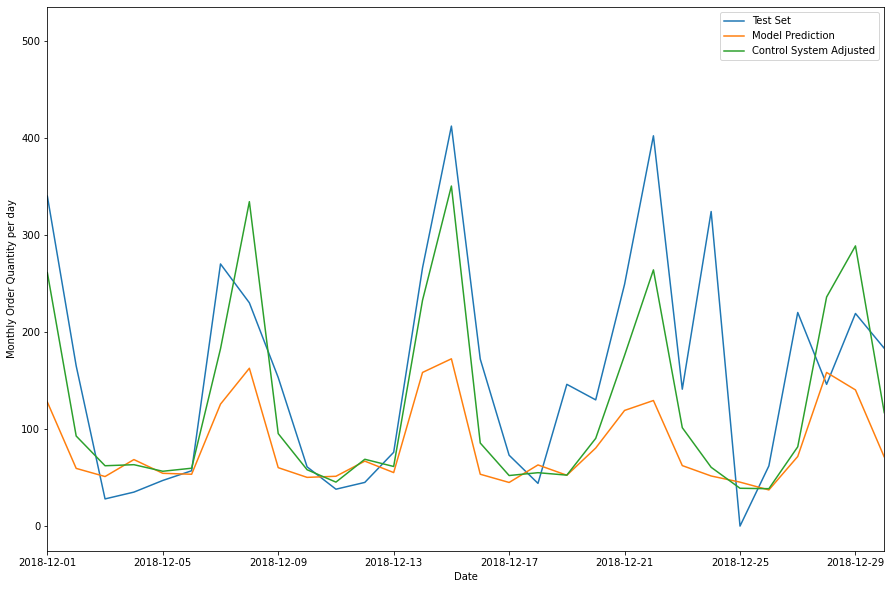

In [75]:
# construct day based Integrator for second restaurant
dayIntegrator = [1,1,1,1,1,1,1];
newPreds = [];
dayPrevStepErr = [0,0,0,0,0,0,0];
for i,row in rest2PredSet.iterrows():
    day = int(row["DoW"])
    dayIntegrator[day] -= dayPrevStepErr[day]*0.05
    newPred = dayIntegrator[day]*row["pred"]
    if(row["Quantity"] != 0): dayPrevStepErr[day]  = (newPred - row["Quantity"])/row["Quantity"]
    else: dayPrevStepErr[day]  = 0
    newPreds.append(newPred)

rest2CSPredErr = (newPreds - rest2PredSet.Quantity)/rest2PredSet.Quantity*100
rest2CSPredErr[rest2CSPredErr > 1e308] = 0

print("rest2 Base error: " + str(np.average(np.absolute(rest2BasePredErr))) + "%")
print("rest2 Cs error: " + str(np.average(np.absolute(rest2CSPredErr))) + "%")
print("error improvement: " + str((np.average(np.absolute(rest2BasePredErr))-np.average(np.absolute(rest2CSPredErr)))/np.average(np.absolute(rest2BasePredErr))*100) + "%")

plt.figure(figsize=(15,10))

plt.plot(rest2PredSet["date"], rest2PredSet.Quantity, label = "Test Set")
plt.plot(rest2PredSet["date"], rest2PredSet.pred, label = "Model Prediction")
plt.plot(rest2PredSet["date"], newPreds, label = "Control System Adjusted")
plt.xlim(pd.Timestamp('2018-12-01'), pd.Timestamp('2018-12-30'))
plt.legend()
plt.xlabel('Date')
plt.ylabel('Monthly Order Quantity per day')
plt.savefig("controlPred.jpg", dpi=300, bbox_inches = "tight")

In [76]:
# perform integral control on restaurnat 2 using IC object
dBIC = integControl()
nparr = dBIC.runControl(rest2PredSet)

t1 = (nparr - rest2PredSet.Quantity)/rest2PredSet.Quantity*100
t1[t1 > 1e308] = 0

print("rest2 Base error: " + str(np.average(np.absolute(rest2BasePredErr))) + "%")
print("rest2 Cs error: " + str(np.average(np.absolute(t1))) + "%")

rest2 Base error: 46.81403302525902%
rest2 Cs error: 39.758004184975654%


Base error: 46.81403302525902%
Cs error: 32.43687067705386%
error improvement: 30.711223577869923%


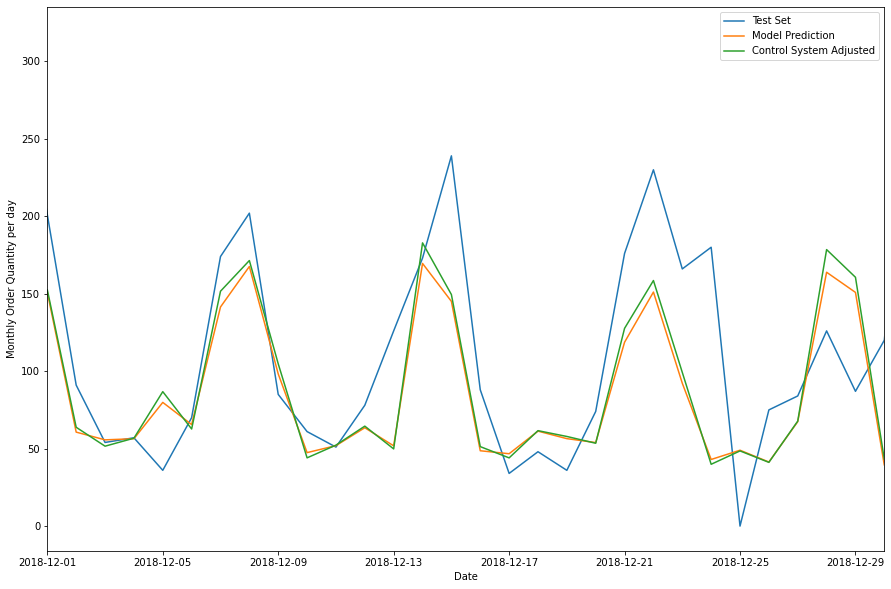

In [77]:
# construct day based Integrator
dayIntegrator = [1,1,1,1,1,1,1];
newPreds = [];
dayPrevStepErr = [0,0,0,0,0,0,0];
for i,row in pred_set.iterrows():
    day = int(row["DoW"])
    dayIntegrator[day] -= dayPrevStepErr[day]*0.05
    newPred = dayIntegrator[day]*row["pred"]
    if(row["Quantity"] != 0): dayPrevStepErr[day]  = (newPred - row["Quantity"])/row["Quantity"]
    else: dayPrevStepErr[day]  = 0
    newPreds.append(newPred)

rest2CSPredErr = (newPreds - pred_set.Quantity)/(pred_set.Quantity.mean())*100
rest2CSPredErr[rest2CSPredErr > 1e308] = 0

print("Base error: " + str(np.average(np.absolute(rest2BasePredErr))) + "%")
print("Cs error: " + str(np.average(np.absolute(rest2CSPredErr))) + "%")
print("error improvement: " + str((np.average(np.absolute(rest2BasePredErr))-np.average(np.absolute(rest2CSPredErr)))/np.average(np.absolute(rest2BasePredErr))*100) + "%")

plt.figure(figsize=(15,10))

plt.plot(pred_set["date"], pred_set.Quantity, label = "Test Set")
plt.plot(pred_set["date"], pred_set.pred, label = "Model Prediction")
plt.plot(pred_set["date"], newPreds, label = "Control System Adjusted")
plt.xlim(pd.Timestamp('2018-12-01'), pd.Timestamp('2018-12-30'))
plt.legend()
plt.xlabel('Date')
plt.ylabel('Monthly Order Quantity per day')
plt.savefig("controlPredR1.jpg", dpi=300, bbox_inches = "tight")

No handles with labels found to put in legend.


49.36039044474218


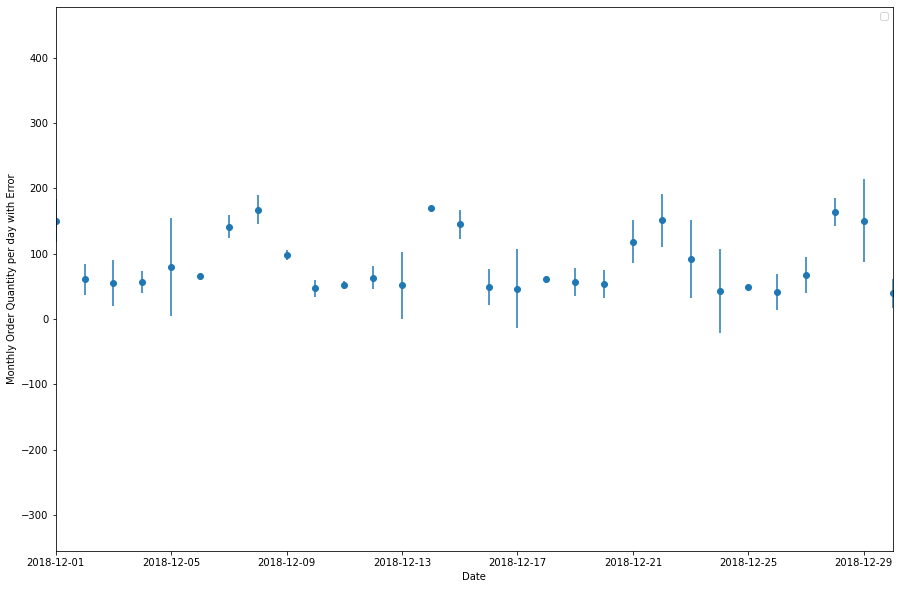

In [78]:
# determine RMSD and draw error graph
err = (pred_set.pred - pred_set.Quantity)
RMSD = np.sqrt(np.mean(err**2))
print(RMSD)
predError

plt.figure(figsize=(15,10))

# plt.scatter(pred_set["date"], predError, label = "Error")
plt.errorbar(pred_set["date"],pred_set.pred, predError, fmt="o")
plt.xlim(pd.Timestamp('2018-12-01'), pd.Timestamp('2018-12-30'))
plt.legend()
plt.xlabel('Date')
plt.ylabel('Monthly Order Quantity per day with Error')
plt.savefig("error.jpg", dpi=300, bbox_inches = "tight")